In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import math
import os

# Part 1: Loading the Data
Here, we load the Quick, Draw! dataset, extract Mini Quick, Draw! and split into train and test directories

In [3]:
# Import the data, split into test and train
data_dir = './quickdraw_simplified/'
limit = 10000
npdata = None
ind2labels = []
labels2ind = {}
nplabels = None

for fname in os.listdir(data_dir):
    # Load and shuffle data, then extract limit number of files
    data_vector = np.load(data_dir + fname)
    np.random.shuffle(data_vector)
    data_vector = npdata_t[:limit, :]
    
    # Get the labels and make a bijection between index and label
    label = fname.split('.')[0]
    ind2labels.append(label)
    labels2ind[label] = len(ind2labels) - 1
    labels = np.full((data_vector.shape[0],1), labels2ind[label])

data = np.c_[data_vector.reshape(len(data_vector), -1), labels.reshape(len(labels), -1)]
images = data[:, :data_vector.size / len(data_vector)].reshape(data_vector.shape)
labels = data[:, data_vector.size / len(data_vector):].reshape(labels.shape)
data = np.random.shuffle(data)

In [5]:
# Try loading something...
def im_and_label(i):
    print(ind2labels[doodle_labels[i][0]])
    plt.imshow(doodle_images[i].reshape(28, 28))

hourglass


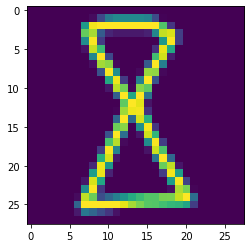

In [28]:
im_and_label(3)

In [32]:
print([ind2labels[i] for i in range(30)])

['lollipop', 'binoculars', 'garden', 'basket', 'penguin', 'washing machine', 'canoe', 'eyeglasses', 'beach', 'screwdriver', 'mouse', 'apple', 'van', 'grapes', 'grass', 'watermelon', 'floor lamp', 'moon', 'zigzag', 'nail', 'leg', 'rollerskates', 'goatee', 'cup', 'anvil', 'suitcase', 'chair', 'drill', 'peanut', 'squirrel']


In [37]:
# First, make a mini-dataset and zip--just select seven categories of drawings, each with 10k images
targets = [0, 4, 6, 7, 11, 17, 23]
mini_quickdraw = np.empty((len(targets), 10000, 28 * 28))
counter = np.zeros(len(targets), dtype=np.int64)

for i in range(len(doodle_images)):
    x = doodle_labels[i][0]
    if x in targets:
        idx = targets.index(x)
        mini_quickdraw[idx, counter[idx]] = doodle_images[i]
        counter[idx] += 1
print(counter)

[10000 10000 10000 10000 10000 10000 10000]


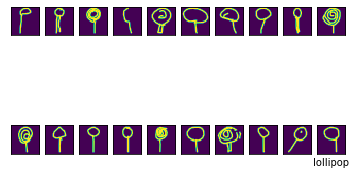

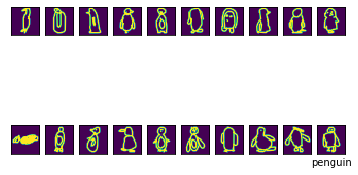

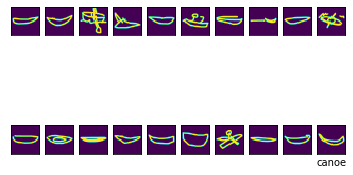

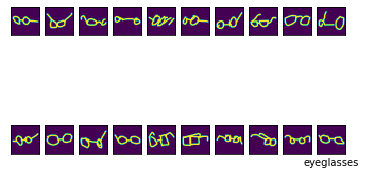

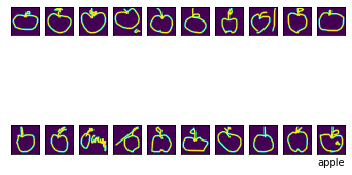

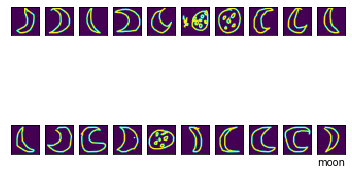

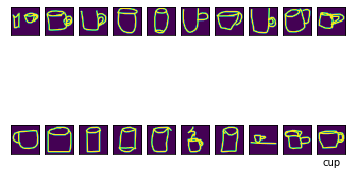

In [39]:
# Inspect a random sample of the images to make sure we've gotten what we want
for j in range(len(targets)):
    sample = np.random.randint(0, 10000, 20)
    for i in range(20):
        plt.subplot(2, 10, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(mini_quickdraw[j, sample[i]].reshape(28, 28))
    plt.xlaforbel(ind2labels[targets[j]])
    plt.show()

In [40]:
# Great, let's save this data--we can save each set of images in a different zip file
np.savez("lollipop", mini_quickdraw[0])

In [42]:
np.savez("canoe", mini_quickdraw[1])
np.savez("penguin", mini_quickdraw[2])
np.savez("eyeglasses", mini_quickdraw[3])
np.savez("apple", mini_quickdraw[4])
np.savez("moon", mini_quickdraw[5])
np.savez("cup", mini_quickdraw[6])

In [50]:
# Try re-loading the new data to make sure this worked

import glob
x = glob.glob('*.npz')
size = 10000
ncat = 7
images = np.empty((ncat, size, 28 * 28))
for i, f in enumerate(x):
    imagest = np.load(f)
    imagest = imagest.f.arr_0
    images[i] = imagest

In [51]:
np.shape(images)

(7, 10000, 784)

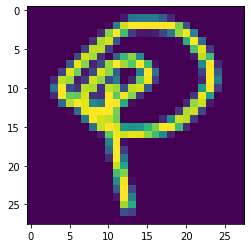

In [52]:
plt.imshow(images[2, 9999].reshape(28, 28))

In [76]:
# Now split the data into permanent train and test directories for use in future datagenerators
d = {0: "lollipop", 1: "canoe", 2: "penguin", 3: "eyeglasses", 4: "apple", 5: "moon", 6: "cup"}

ntest = 1000
for cat in range(len(mini_quickdraw)):
    for i in range(len(mini_quickdraw[cat])):
        if i < ntest:
            np.savez("images/test/" + d[cat] + "_" + str(i), mini_quickdraw[cat, i])
        else:
            np.savez("images/train/" + d[cat] + "_" + str(i), mini_quickdraw[cat, i])

In [72]:
print(len(glob.glob('images/*.npz')))

70000


In [79]:
!ls images/

test          test.tar.bz2  train         train.tar.bz2


# Part 2: Pre-Processing
To get started, I want to replicate the tutorial for doing transfer learning using a pre-trained convnet found here: https://www.tensorflow.org/tutorials/images/transfer_learning

Unfortunately, it turns out a fair amount of pre-processing is required to get the data into a format appropriate for the MobileNet used in this tutorial. The (sometimes meandering) pre-processing steps I took to get this to work is documented below, but I later wrote a small data loading library `load_data.py` that accomplishes the steps below more programmatically that is used throughout subsequent notebooks.

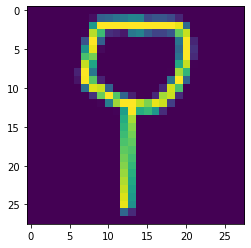

In [2]:
# Load the data one again
import pathlib

dim = 28
data_dir = pathlib.Path('images/')
files = list(data_dir.glob('train/*.npz'))
train_image_count = len(files)
train_images_old = np.empty((train_image_count, dim, dim))
train_labels = np.array([item.name.split("_")[0] for item in data_dir.glob('train/*')])

for i, f in enumerate(files):
    tmp = np.load(f)
    train_images_old[i] = tmp.f.arr_0.reshape(dim, dim)
    if i == 1:
        plt.imshow(train_images_old[i])

files = list(data_dir.glob('test/*.npz'))
test_image_count = len(files)
test_images_old = np.empty((test_image_count, dim, dim))
test_labels = np.array([item.namef for item in data_dir.glob('test/*')])

for i, f in enumerate(files):
    tmp = np.load(f)
    test_images_old[i] = tmp.f.arr_0.reshape(dim, dim)

In [6]:
files[0].name.split("_")[0]

'cup'

In [3]:
print(test_labels[1])

lollipop


In [4]:
# Oops, I did something silly--we don't want string labels! We want a vector!
d = {"lollipop":0, "canoe":1, "penguin":2, "eyeglasses":3, "apple":4, "moon":5, "cup":6}
test_str_labels = test_labels
train_str_labels = train_labels

train_labels = np.empty(train_image_count, dtype=np.int32)
test_labels = np.empty(test_image_count, dtype=np.int32)

for i in range(len(train_labels)):
    train_labels[i] = int(d[train_str_labels[i]])

for i in range(len(test_labels)):
    test_labels[i] = int(d[test_str_labels[i]])

In [5]:
print(test_labels[1])

0


In [6]:
# Quick check to make sure I understand how one-hot encoding works
x = [3, 2, 6, 1, 2, 5, 0, 4]
print(tf.one_hot(x, depth=7).numpy())

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]


In [7]:
# Now, let's convert all our labels in this one-hot form, with a depth of 7 since we have 7 categories
train_labels = tf.one_hot(train_labels, depth=7)
test_labels = tf.one_hot(test_labels, depth=7)

In [8]:
print("Number of train labels " + str(train_labels.shape))
print("Number of train samples " + str(train_images_old.shape))
print("Number of test labels " + str(test_labels.shape))
print("Number of test samples " + str(test_images_old.shape))

# Note that eventually I should make this better by writing my own generator that rotates/rescales

Number of train labels (63000, 7)
Number of train samples (63000, 28, 28)
Number of test labels (7000, 7)
Number of test samples (7000, 28, 28)


tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32)
255.0
0.0


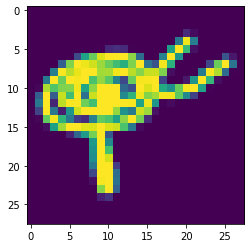

In [9]:
i = 7
plt.imshow(test_images_old[i])
print(test_labels[i])
print(np.max(test_images_old[i]))
print(np.min(test_images_old[i]))

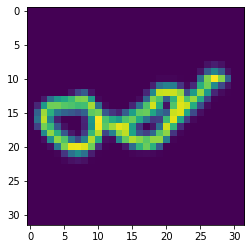

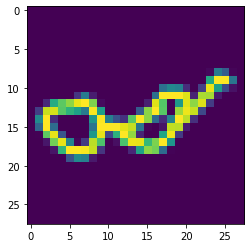

In [10]:
# Note: I eventually realized that I need to upsample my images, as many pre-trained convnets are meant
# for use on larger images than 28x28! My code for doing this is below

from scipy import interpolate

def upsample(dim_new, arr):
    # NB: this only works on 2D arrays!
    dim_old = np.shape(arr)[0]
    xnew = np.linspace(0, dim_old, dim_new)
    ynew = np.linspace(0, dim_old, dim_new)
    assert np.shape(arr)[0] == np.shape(arr)[1]
    x = np.arange(dim_old)
    f = interpolate.interp2d(x, x, arr, kind='linear')
    return f(xnew, ynew)

# Quick test
plt.imshow(upsample(32, test_images_old[5]))
plt.show()
plt.imshow(test_images_old[5])
plt.show()

IMG_SIZE = 96 # All images will be resized to 96 x 96

In [11]:
# Upsample the whole dataset!
test_images_resize = np.empty((test_image_count, IMG_SIZE, IMG_SIZE))
train_images_resize = np.empty((train_image_count, IMG_SIZE, IMG_SIZE))

for i, img in enumerate(test_images_old):
    test_images_resize[i] = upsample(IMG_SIZE, test_images_old[i])

for i, img in enumerate(train_images_old):
    train_images_resize[i] = upsample(IMG_SIZE, train_images_old[i])
    
train_images_old = train_images_resize
test_images_old = test_images_resize

In [12]:
print(np.shape(train_images_old))
print(np.shape(test_images_old))

(63000, 28, 28)
(7000, 28, 28)


In [27]:
# Many pre-trained convnets are meant to be used on color images, so we need to add extra channel axes:
train_images = np.empty((train_images_old.shape[0], IMG_SIZE, IMG_SIZE, 3))
test_images = np.empty((test_images_old.shape[0], IMG_SIZE, IMG_SIZE, 3))

train_images = np.stack((train_images_old, train_images_old, train_images_old), axis=3)
test_images = np.stack((test_images_old, test_images_old, test_images_old), axis=3)

In [29]:
# Lastly, we center our data in [-1, 1]
def center(image):
    image = (image / 127.5) - 1
    return image

In [30]:
for i, img in enumerate(train_images):
    train_images[i] = center(img)

for i, img in enumerate(test_images):
    test_images[i] = center(img)

print(np.shape(test_images))    
print(np.shape(test_labels))    

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

print(train_dataset)
print(test_dataset)

(7000, 28, 28, 1)
(7000, 7)
<TensorSliceDataset shapes: ((28, 28, 1), (7,)), types: (tf.float64, tf.float32)>
<TensorSliceDataset shapes: ((28, 28, 1), (7,)), types: (tf.float64, tf.float32)>


In [52]:
print(np.shape(train_images))    
print(np.shape(train_labels))  

(63000, 28, 28, 1)
(63000, 7)


In [60]:
# Match the tutorial's naming conventions
train = train_dataset
test = test_dataset

BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000

# Make a validation partition
validation = train.take(750) 
train = train.skip(750)

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [61]:
for image_batch, label_batch in train_batches.take(1):
    pass
image_batch.shape

TensorShape([64, 28, 28, 1])

# Part 3: Feature Extraction

Finally, after all of this effort, we are ready to start following the steps of the tutorial! The code below is pretty much a verbatim reproduction of the tensorflow tutorial code (with small modifications for my own dataset and some added comments).

In [222]:
# Finally, we're ready to download our model
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [278]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


In [224]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [225]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [283]:
# Modify the "top" of the network to have seven output nodes (one per category)
prediction_layer = tf.keras.layers.Dense(7, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 7)


In [284]:
# Put the entire model together
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [285]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [286]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 8,967
Non-trainable params: 2,257,984
_________________________________________________________________


In [289]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Train for 1946 steps, validate for 24 steps
Epoch 1/10
1946/1946 [==============================] - 553s 284ms/step - loss: 0.1399 - accuracy: 0.9506 - val_loss: 0.2982 - val_accuracy: 0.9036
Epoch 2/10
1946/1946 [==============================] - 556s 286ms/step - loss: 0.0783 - accuracy: 0.9749 - val_loss: 0.2952 - val_accuracy: 0.9051
Epoch 3/10
1946/1946 [==============================] - 542s 278ms/step - loss: 0.0712 - accuracy: 0.9773 - val_loss: 0.3005 - val_accuracy: 0.9040
Epoch 4/10
1946/1946 [==============================] - 528s 271ms/step - loss: 0.0675 - accuracy: 0.9782 - val_loss: 0.3025 - val_accuracy: 0.9051
Epoch 5/10
1946/1946 [==============================] - 473s 243ms/step - loss: 0.0650 - accuracy: 0.9791 - val_loss: 0.3017 - val_accuracy: 0.9048
Epoch 6/10
1946/1946 [==============================] - 523s 269ms/step - loss: 0.0632 - accuracy: 0.9797 - val_loss: 0.3055 - val_accuracy: 0.9042
Epoch 7/10
1946/1946 [==============================] - 586s 301ms/s

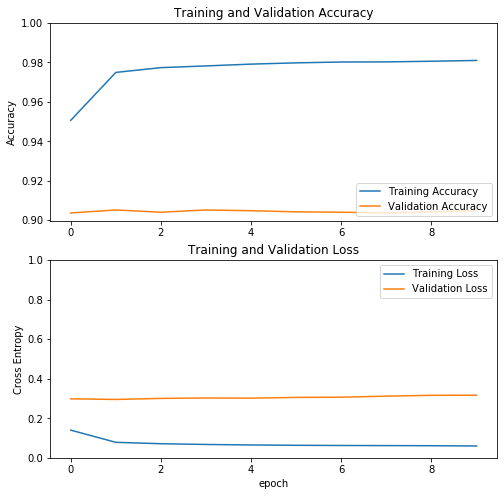

In [290]:
# Finally, we can examine the learning curves to see how we did!
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Part 4: Fine Tuning

In [291]:
# This time, we make the base of the model trainable
base_model.trainable = True

In [292]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards (rn, we are fine tuning the top 55 layers)
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  155


In [293]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 8967      
Total params: 2,266,951
Trainable params: 1,871,559
Non-trainable params: 395,392
_________________________________________________________________


In [294]:
len(model.trainable_variables)

58

In [295]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Train for 1946 steps, validate for 24 steps
Epoch 10/20
1946/1946 [==============================] - 636s 327ms/step - loss: 0.0500 - accuracy: 0.9841 - val_loss: 0.4428 - val_accuracy: 0.8286
Epoch 11/20
1946/1946 [==============================] - 708s 364ms/step - loss: 0.0376 - accuracy: 0.9877 - val_loss: 0.4236 - val_accuracy: 0.8501
Epoch 12/20
1946/1946 [==============================] - 657s 338ms/step - loss: 0.0309 - accuracy: 0.9897 - val_loss: 0.4144 - val_accuracy: 0.8564
Epoch 13/20
1946/1946 [==============================] - 615s 316ms/step - loss: 0.0260 - accuracy: 0.9914 - val_loss: 0.4430 - val_accuracy: 0.8638
Epoch 14/20
1946/1946 [==============================] - 880s 452ms/step - loss: 0.0227 - accuracy: 0.9924 - val_loss: 0.4333 - val_accuracy: 0.8710
Epoch 15/20
1946/1946 [==============================] - 732s 376ms/step - loss: 0.0198 - accuracy: 0.9933 - val_loss: 0.4255 - val_accuracy: 0.8792
Epoch 16/20
1946/1946 [==============================] - 860s 

In [296]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

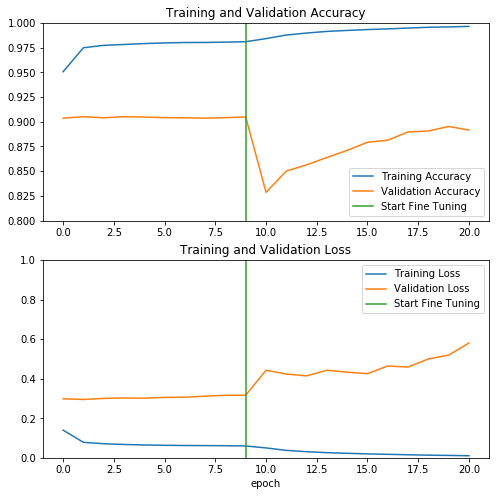

In [297]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()